In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

<h3> Чтение и препроцессинг данных </h3>

In [2]:
train_filename = "cust_class_train.csv"
test_filename = "cust_class_test.csv"

In [3]:
train_data = pd.read_csv(train_filename)
test_data = pd.read_csv(test_filename)

In [4]:
train_data = train_data.set_index("ID")
test_data = test_data.set_index("ID")

In [5]:
train_data.Ever_Married = train_data.Ever_Married.astype('category')
train_data.Graduated = train_data.Graduated.astype('category')
train_data.Profession = train_data.Profession.astype('category')
train_data.Spending_Score = train_data.Spending_Score.astype('category')
train_data.Var_1 = train_data.Var_1.astype('category')
train_data.Segmentation = train_data.Segmentation.astype('category')

In [6]:
drop_rows = train_data[
    (train_data.Age < train_data.Age.quantile(0.005)) | 
    (train_data.Age > train_data.Age.quantile(0.995))].index

In [7]:
train_data = train_data.drop(drop_rows)

In [8]:
train_data.Work_Experience = train_data.Work_Experience.fillna(0)

In [9]:
train_data.Family_Size = train_data.Family_Size.fillna(1)

In [10]:
train_data.Ever_Married = train_data.Ever_Married.fillna(train_data.Ever_Married.mode()[0])
train_data.Graduated = train_data.Graduated.fillna(train_data.Graduated.mode()[0])
train_data.Profession = train_data.Profession.fillna(train_data.Profession.mode()[0])
train_data.Var_1 = train_data.Var_1.fillna(train_data.Var_1.mode()[0])

In [11]:
train_data.Gender = pd.factorize(train_data.Gender)[0]
train_data.Ever_Married = pd.factorize(train_data.Ever_Married)[0]
train_data.Graduated = pd.factorize(train_data.Graduated)[0]


In [12]:
train_data = pd.concat((train_data, pd.get_dummies(train_data.Profession)), axis=1)
train_data = train_data.drop(['Profession'], axis=1)

In [13]:
train_data = pd.concat((train_data, pd.get_dummies(train_data.Spending_Score)), axis=1)
train_data = train_data.drop(['Spending_Score'], axis=1)

In [14]:
train_data = pd.concat((train_data, pd.get_dummies(train_data.Var_1)), axis=1)
train_data = train_data.drop(['Var_1'], axis=1)

In [15]:
train_data.loc[:, train_data.columns != 'Segmentation'] = (
    train_data.loc[:, train_data.columns != 'Segmentation'] - \
    train_data.loc[:, train_data.columns != 'Segmentation'].mean(axis = 0)) / \
    train_data.loc[:, train_data.columns != 'Segmentation'].std(axis = 0)

In [16]:
X = train_data.drop(['Segmentation'], axis=1)

In [17]:
y = train_data.Segmentation

In [18]:
mapping = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3}

In [19]:
y = y.map(lambda x: mapping[x])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [22]:
def plot_clustering(x_data, y_data):
    reduced_data = PCA(n_components=2).fit_transform(x_data)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = y_data)

<h3> KMeans <h3>

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [102]:
k_means = KMeans(n_clusters=4)
k_means.fit(X_train, y_train)
pred_y = k_means.predict(X_test)
print(f"Validation accuracy: {accuracy_score(y_test, pred_y)}")
print(f"Train accuracy: {accuracy_score(y_train, k_means.predict(X_train))}")

Validation accuracy: 0.4163346613545817
Train accuracy: 0.3982403718459495


<h5> Train data real clustering </h5>

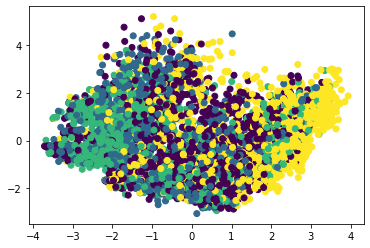

In [103]:
plot_clustering(X_train, y_train)

<h5> Train data predicted clustering </h5>

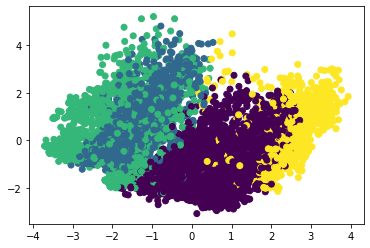

In [104]:
Z = k_means.predict(X_train)
plot_clustering(X_train, Z)

Real

(array([1431.,    0.,    0., 1425.,    0.,    0., 1507.,    0.,    0.,
        1661.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

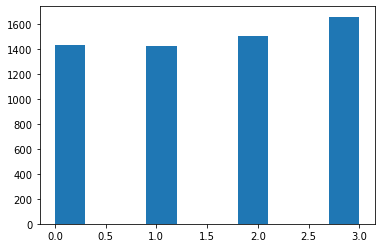

In [107]:
plt.hist(y_train)

Predicted

(array([2265.,    0.,    0., 1490.,    0.,    0., 1134.,    0.,    0.,
        1135.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

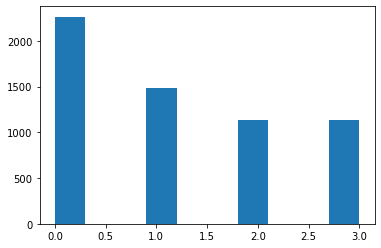

In [106]:
plt.hist(k_means.labels_)

In [112]:
y_train_pred = k_means.predict(X_train)
diff = np.sum(y_train != y_train_pred)

In [115]:
print(f"{diff / len(y_train_pred)}% меток кластеров не совпадают с метками классов")

0.6017596281540505% меток кластеров не совпадают с метками классов


<h3> DBSCAN </h3>

In [116]:
from sklearn.cluster import DBSCAN

In [134]:
from sklearn.metrics.pairwise import euclidean_distances
mean_dist = euclidean_distances(X_train[0:1000]).mean()
print(mean_dist)

6.865107101892511


In [128]:
for n in range(2, 10):
    dbscan = DBSCAN(eps = mean_dist, min_samples = n)
    pred_y = dbscan.fit_predict(X_train, y_train)
    print(f"Samples: {n}, Accuracy: {accuracy_score(y_train, pred_y)}")

Samples: 2, Accuracy: 0.23671978751660028
Samples: 3, Accuracy: 0.23671978751660028
Samples: 4, Accuracy: 0.23671978751660028
Samples: 5, Accuracy: 0.23671978751660028
Samples: 6, Accuracy: 0.23671978751660028
Samples: 7, Accuracy: 0.23671978751660028
Samples: 8, Accuracy: 0.23671978751660028
Samples: 9, Accuracy: 0.23671978751660028


(array([5860.,    0.,    0.,    0.,    0.,   67.,    0.,    0.,    0.,
          97.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

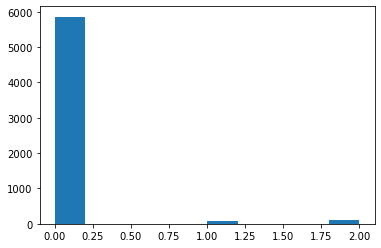

In [129]:
plt.hist(dbscan.labels_)

Почти все точки в одном кластере. Попробуем меньшее расстояние.

In [135]:
mean_dist = mean_dist / 2
for n in range(2, 10):
    dbscan = DBSCAN(eps = mean_dist, min_samples = n)
    pred_y = dbscan.fit_predict(X_train, y_train)
    print(f"Samples: {n}, Accuracy: {accuracy_score(y_train, pred_y)}")

Samples: 2, Accuracy: 0.0899734395750332
Samples: 3, Accuracy: 0.0899734395750332
Samples: 4, Accuracy: 0.0899734395750332
Samples: 5, Accuracy: 0.0899734395750332
Samples: 6, Accuracy: 0.0899734395750332
Samples: 7, Accuracy: 0.0899734395750332
Samples: 8, Accuracy: 0.0899734395750332
Samples: 9, Accuracy: 0.0899734395750332


(array([2638.,  687.,  857.,  546.,  438.,  287.,  284.,  104.,   88.,
          95.]),
 array([-1. ,  3.9,  8.8, 13.7, 18.6, 23.5, 28.4, 33.3, 38.2, 43.1, 48. ]),
 <a list of 10 Patch objects>)

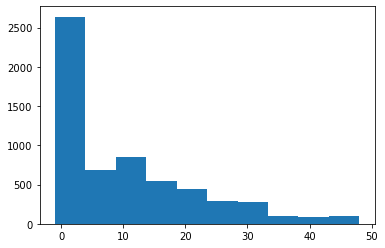

In [136]:
plt.hist(dbscan.labels_)

Уже лучше, но все еще много. Попробуем чуть уменьшить

In [137]:
mean_dist = mean_dist * (3 / 4)
for n in range(2, 20):
    dbscan = DBSCAN(eps = mean_dist, min_samples = n)
    pred_y = dbscan.fit_predict(X_train, y_train)
    print(f"Samples: {n}, Accuracy: {accuracy_score(y_train, pred_y)}")

Samples: 2, Accuracy: 0.0698871181938911
Samples: 3, Accuracy: 0.0698871181938911
Samples: 4, Accuracy: 0.0698871181938911
Samples: 5, Accuracy: 0.0698871181938911
Samples: 6, Accuracy: 0.0698871181938911
Samples: 7, Accuracy: 0.0698871181938911
Samples: 8, Accuracy: 0.0698871181938911
Samples: 9, Accuracy: 0.0698871181938911
Samples: 10, Accuracy: 0.0698871181938911
Samples: 11, Accuracy: 0.05444887118193891
Samples: 12, Accuracy: 0.05444887118193891
Samples: 13, Accuracy: 0.05461487383798141
Samples: 14, Accuracy: 0.05461487383798141
Samples: 15, Accuracy: 0.05461487383798141
Samples: 16, Accuracy: 0.05461487383798141
Samples: 17, Accuracy: 0.07088313413014609
Samples: 18, Accuracy: 0.07088313413014609
Samples: 19, Accuracy: 0.07088313413014609


(array([2623.,  302.,  924.,  506.,  473.,  413.,  279.,  250.,  133.,
         121.]),
 array([-1. ,  2.9,  6.8, 10.7, 14.6, 18.5, 22.4, 26.3, 30.2, 34.1, 38. ]),
 <a list of 10 Patch objects>)

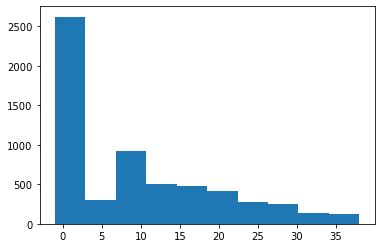

In [138]:
plt.hist(dbscan.labels_)

Большинство значений все равно в одном кластере

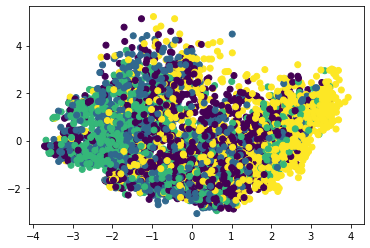

In [139]:
plot_clustering(X_train, y_train)

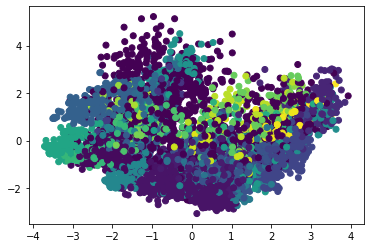

In [140]:
plot_clustering(X_train, pred_y)

<h3> Birch </h3>

In [141]:
from sklearn.cluster import Birch

In [154]:
for t in np.arange(0.5, 5, 0.5):
    for n in range(10, 200, 10):
        birch = Birch(n_clusters=4, branching_factor=n)
        birch.fit(X_train, y_train)
        pred_y = birch.predict(X_test)
        print(f"Threshold: {t}, Branchs: {n}, Validation accuracy: {accuracy_score(y_test, pred_y)}, Train accuracy: {accuracy_score(y_train, birch.predict(X_train))}")

Threshold: 0.5, Branchs: 10, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 0.5, Branchs: 20, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 0.5, Branchs: 30, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2360557768924303
Threshold: 0.5, Branchs: 40, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 0.5, Branchs: 50, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2362217795484728
Threshold: 0.5, Branchs: 60, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 0.5, Branchs: 70, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 0.5, Branchs: 80, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 0.5, Branchs: 90, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2360557768924303
Threshold: 0.5, Branchs: 100, Validation

Threshold: 2.5, Branchs: 20, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 2.5, Branchs: 30, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2360557768924303
Threshold: 2.5, Branchs: 40, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 2.5, Branchs: 50, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2362217795484728
Threshold: 2.5, Branchs: 60, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 2.5, Branchs: 70, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 2.5, Branchs: 80, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 2.5, Branchs: 90, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2360557768924303
Threshold: 2.5, Branchs: 100, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2360557768924303
Threshold: 2.5, Branchs: 110, Validation

Threshold: 4.5, Branchs: 30, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2360557768924303
Threshold: 4.5, Branchs: 40, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 4.5, Branchs: 50, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2362217795484728
Threshold: 4.5, Branchs: 60, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 4.5, Branchs: 70, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 4.5, Branchs: 80, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 4.5, Branchs: 90, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2360557768924303
Threshold: 4.5, Branchs: 100, Validation accuracy: 0.26294820717131473, Train accuracy: 0.2360557768924303
Threshold: 4.5, Branchs: 110, Validation accuracy: 0.26245019920318724, Train accuracy: 0.23705179282868527
Threshold: 4.5, Branchs: 120, Validatio

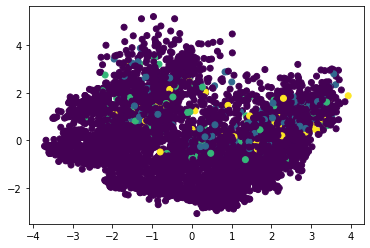

In [156]:
pred_y = birch.predict(X_train)
plot_clustering(X_train, pred_y)

Birch так же, как и dbscan определяет все объекты в один кластер

<h3> Вывод </h3>

Алгоритмы кластеризации не самое лучшее решение для этой задачи. Хотя, kmeans показал себя неплохо.